In [1]:
from enum import IntEnum
from typing import Tuple
from collections import defaultdict
import random
import math

import pyrosm
import pandas as pd
import numpy as np
import geopandas
import rasterio
import rioxarray as rxr
from shapely.geometry import mapping
from matplotlib import pyplot as plt
from rasterio.crs import CRS
from scipy.spatial import cKDTree
from scipy import stats

/mnt/c/Users/Alfred/CLionProjects/outbreak-sim/python/venv/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
# This should be picked appropriately for the boundary area to avoid distortion, this example is in the UK so using 27700
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700 

### Step 1: Acquire Boundary and Data from OpenStreetMap

In [3]:
# Get OpenStreetMap data
fp = pyrosm.get_data("Greater London", update=True)
osm = pyrosm.OSM(fp)

Downloaded Protobuf data 'greater-london-latest.osm.pbf' (65.14 MB) to:
'/tmp/pyrosm/greater-london-latest.osm.pbf'


In [4]:
# Read all boundaries using the default settings
boundaries = osm.get_boundaries()
boundaries.head(3) # left as an example to see possible Boundary choices

,name,website,admin_level,boundary,start_date,id,timestamp,version,changeset,geometry,tags,osm_type
0,London Borough of Sutton,https://www.sutton.gov.uk/,8,administrative,None,798271,1602273393,40,0,"POLYGON ((-0.24505 51.38004, -0.24505 51.38010...","{""council_name"":""Sutton Council"",""designation""...",relation
1,City of Westminster,https://www.westminster.gov.uk/,8,administrative,None,3689101,1611414639,89,0,"POLYGON ((-0.21605 51.52792, -0.21604 51.52793...","{""council_name"":""Westminster City Council"",""de...",relation
2,Royal Borough of Kensington and Chelsea,https://www.rbkc.gov.uk/,8,administrative,None,3740894,1611414639,55,0,"POLYGON ((-0.22847 51.53032, -0.22841 51.53029...","{""council_name"":""Royal Borough of Kensington a...",relation


In [5]:
# pick a small subset for testing
boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")

# recreate the pyrosm object to the chosen boundary

# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [6]:
%%time
# get all residential buildings as well as ones without a specific tag
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)
residential_buildings = residential_buildings[['building', 'geometry']]

CPU times: user 28.2 s, sys: 3.08 s, total: 31.3 s
Wall time: 31.3 s


In [7]:
%%time
# crudely get all places that might be considered workplaces
# pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois_filter = {"shop": True,"amenity": True}
pois = osm.get_pois(custom_filter=pois_filter)

office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)

office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)

CPU times: user 3.2 s, sys: 109 ms, total: 3.31 s
Wall time: 3.3 s


In [8]:
%%time
# combine the locations of all of the crude workplaces
trimmed_work = pois[['geometry']].copy()
trimmed_work = trimmed_work.append(offices[['geometry']]).append(office_buildings[['geometry']])
trimmed_work = trimmed_work.reset_index()
orig_crs = trimmed_work.crs
trimmed_work = trimmed_work.to_crs(OUT_CRS) # convert CRS to the final CRS for more correct centroids
trimmed_work['geometry'] = trimmed_work.geometry.convex_hull.centroid  # we use the convex hull because otherwise we get wildly incorrect points for non-convex polygons results
trimmed_work = trimmed_work.to_crs(orig_crs) # convert back for now
# trimmed_work.plot(markersize=0.1)
del pois, offices, office_buildings,

CPU times: user 375 ms, sys: 15.6 ms, total: 391 ms
Wall time: 380 ms


### Step 2: Acquire Population Count for Selected Boundary

In [9]:
# this can probably be replaced with an API call (https://www.worldpop.org/sdi/introapi) but isn't currently implemented 
uk_wp = rxr.open_rasterio('./data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze() # acquired from https://www.worldpop.org/geodata/summary?id=29480
print(uk_wp.rio.crs)  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary
wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))

EPSG:4326


Total Population: 321484
Buildings from OSM, Residential: 11819, Workplaces: 6133


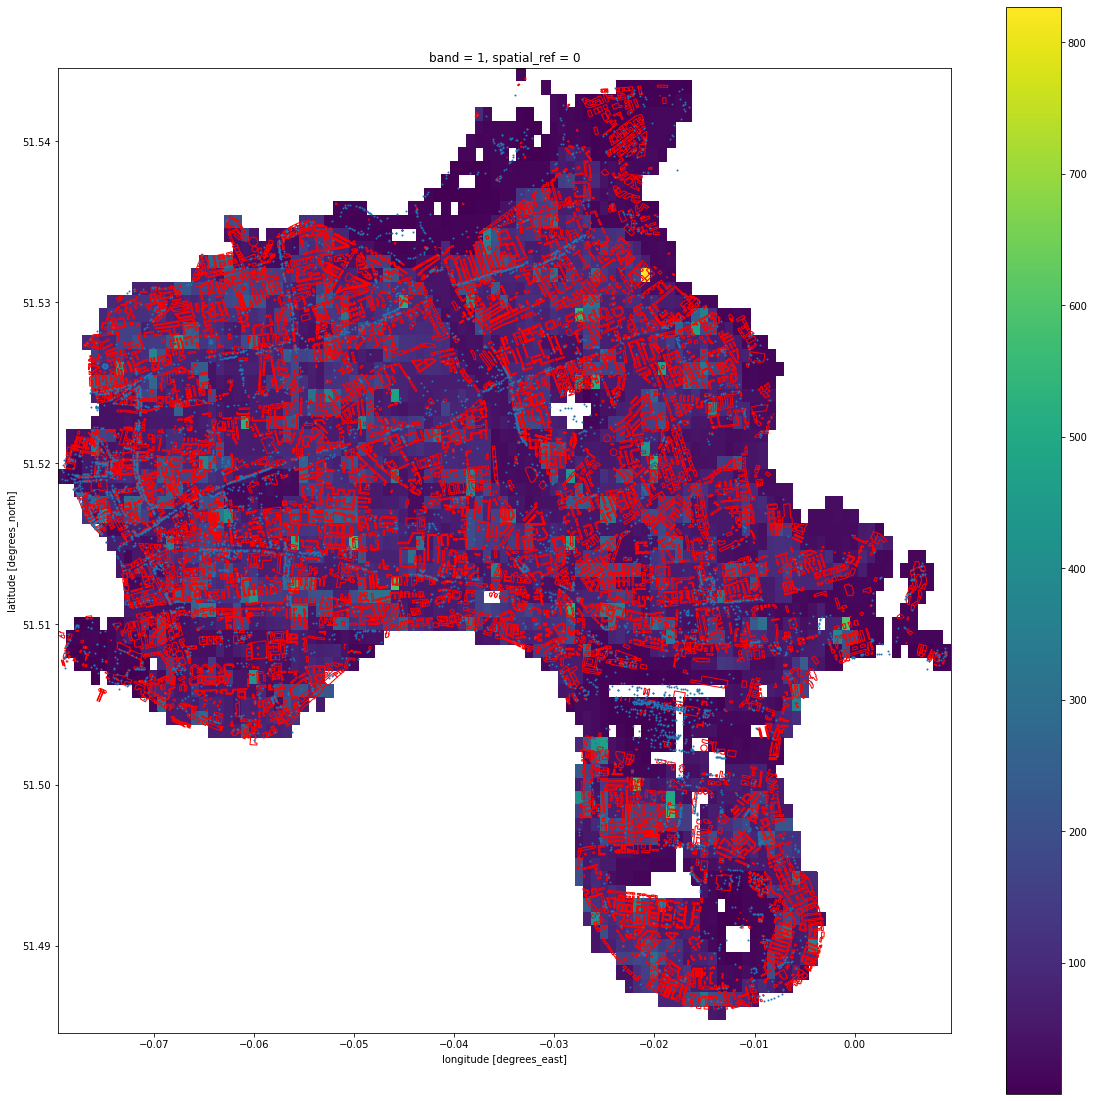

In [10]:
fig, ax = plt.subplots(figsize=(20, 20))
wp_clipped.plot(ax=ax)
residential_buildings.plot(ax=ax, facecolor='none', edgecolor='r')
trimmed_work.plot(ax=ax, markersize=1)
print(f"Total Population: {int(wp_clipped.sum())}")
print(f"Buildings from OSM, Residential: {len(residential_buildings)}, Workplaces: {len(trimmed_work)}")
del fig, ax

### Step 3: Setup some Distributions and Classes

In [11]:
# this section would be a good place to add params census data

In [12]:
projected_boundary = boundary.copy().set_crs("EPSG:4326").to_crs(OUT_CRS)
bounds = projected_boundary.bounds
(boundary_minx, boundary_maxx, boundary_miny, boundary_maxy)  = (bounds.loc[bounds.index[0], 'minx'], bounds.loc[bounds.index[0], 'maxx'], bounds.loc[bounds.index[0], 'miny'], bounds.loc[bounds.index[0], 'maxy'])

In [13]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [14]:
%%time
nx, ny = wp_clipped.sizes['x'], wp_clipped.sizes['y']
x, y = wp_clipped.rio.transform() * np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5)

# GeoDataFrame of centres of raster cells, indexed by their respective ravelled index
raster_coords = geopandas.GeoDataFrame({'ravelled_index': np.arange(x.size)}, geometry=geopandas.points_from_xy(x.ravel(), y.ravel()), crs="EPSG:4326")
residences_in_radius = cKDQueryRadius(raster_coords, residential_buildings)
del nx, ny, x, y

CPU times: user 2.31 s, sys: 125 ms, total: 2.44 s
Wall time: 2.42 s


##### Household Size Distribution

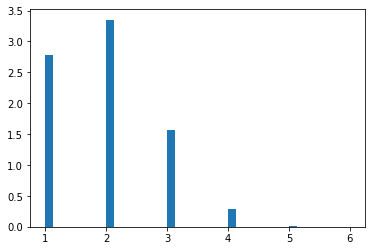

In [15]:
# initial values pretty much completely guessed, should be built off census data
lower, upper = 1, 8
mu, sigma = 2.2, 0.98

household_size_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
fig, ax = plt.subplots(1, 1)
ax.hist(household_size_dist.rvs(100_000).astype(int), density=True, bins=40)
plt.show()
del fig, ax

##### Workplace Size Distribution

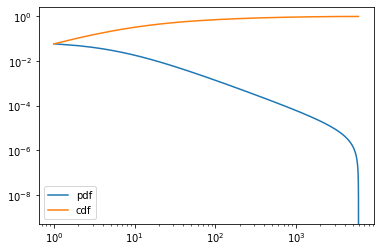

In [16]:
# inspired from https://www.nature.com/articles/nature04795 supplementary information
def workplace_size_truncated_power_law(m_max, a, c):
    m = np.arange(1, m_max + 1, dtype='float')
    pmf = (
            (
                    (
                            ((1 + (m_max / a))
                             /
                             (1 + (m / a)))
                            ** c)
                    - 1)
            /
            ((
                    ((1 + (m_max / a)) ** c)
                    - 1)))
    pmf /= pmf.sum()

    return stats.rv_discrete(values=(range(1, m_max + 1), pmf))

max_size = 5920
workplace_size_dist = workplace_size_truncated_power_law(m_max=max_size, a=5.36, c=1.34)

x = np.arange(1, max_size + 1)
fig, ax = plt.subplots()
y_pdf = workplace_size_dist.pmf(x)
y_cdf = workplace_size_dist.cdf(x)
ax.set_xscale(value="log")
ax.set_yscale(value="log")
ax.plot(x, y_pdf, label='pdf')
ax.plot(x, y_cdf, label='cdf')
ax.legend()
del x, fig, ax

In [17]:
class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
        

people = []

def add_new_person(household_uid, pos):
    age = random.randint(0, 108)  # Todo update this
    
    new_person = Person(uid=len(people), household_uid=household_uid, age=age, pos=pos)
    people.append(new_person)
    
    return new_person

In [18]:
class Household():
    def __init__(self, uid, max_inhabitants, pos: Tuple[float, float]):
        self.uid = uid
        self.inhabitants = 0
        self.max_inhabitants = max_inhabitants
        self.pos = pos
    
    def to_dict(self):
        return {
            'uid': self.uid,
            'inhabitants': self.inhabitants,
            'max_inhabitants': self.max_inhabitants,
            'pos': self.pos,
        }
    
households = []

def add_new_household(pos_geometry):
    max_inhabitants = household_size_dist.rvs(1)[0]
    
    new_household = Household(uid=len(households), max_inhabitants=max_inhabitants, pos=pos_geometry)
    households.append(new_household)
    
    return new_household

In [19]:
class ResidenceType(IntEnum):
    HOUSE = 0
    SMALL_FLATS = 1  # Perhaps a few floors or flats in one building
    LARGE_FLATS = 2  # Generally high-rise, shared lifts, etc.


# Again basically random numbers, need to be brought in from Census
residence_params = {
    'max_household_capacity': 7,
    ResidenceType.HOUSE: {
        'max_households': 2
    },
    ResidenceType.SMALL_FLATS: {
        'max_households': 10
    },
    ResidenceType.LARGE_FLATS: {
        'max_households': 150
    }
}

residential_buildings['residence_type'] = ResidenceType.HOUSE
residential_buildings.loc[residential_buildings['building'].isin(['apartments', 'flats']), 'residence_type'] = ResidenceType.SMALL_FLATS
residential_buildings.drop('building', axis='columns', inplace=True)

### Person Generation and Household Allocation

In [20]:
%%time
residences_to_households = defaultdict(lambda: [])
residential_buildings = residential_buildings.to_crs(OUT_CRS)

# reset lists
households = []
people = []
failures = 0

# for each tile of population
for row in range(wp_clipped.shape[0]):
    for col in range(wp_clipped.shape[1]):
        index = (row, col)
        people_at_tile = wp_clipped[row, col]
        
        if np.isnan(people_at_tile):
            continue
        
        # residences near the center of the tile
        local_residences_indices = residences_in_radius.loc[np.ravel_multi_index(index, wp_clipped.shape), 'Elements in Radius']
        
        for _ in range(int(people_at_tile)):
            shuffled_indices = np.random.permutation(local_residences_indices)

            chosen_household = None

            for residence_index in shuffled_indices:
                households_at_residence = [households[household_uid] for household_uid in residences_to_households[residence_index]]
                possible_households = [household for household in households_at_residence if household.inhabitants < household.max_inhabitants]

                if len(possible_households) != 0:
                    chosen_household = random.choice(possible_households)
                    chosen_household.inhabitants += 1
                    break
                else:
                    building_type = residential_buildings.loc[residence_index, 'residence_type']
                    
                    if len(households_at_residence) < residence_params[building_type]['max_households']:
                        pos = residential_buildings.loc[residence_index].geometry.centroid
                        pos = (pos.x, pos.y)
                        chosen_household = add_new_household(pos)
                        residences_to_households[residence_index].append(chosen_household.uid)
                        
                        chosen_household.inhabitants += 1
                        
            else:  # failed to find an available household, or residence to make a new household in, so upgrade a residence 
                smaller_residences_indices = [residence_index for residence_index in local_residences_indices 
                                              if residential_buildings.loc[residence_index, 'residence_type'] != ResidenceType.LARGE_FLATS]
                
                if len(smaller_residences_indices) != 0:
                    chosen_residence_index = random.choice(smaller_residences_indices)
                    residential_buildings.loc[chosen_residence_index, 'residence_type'] = ResidenceType(residential_buildings.loc[chosen_residence_index, 'residence_type'] + 1)
                    
                    pos = residential_buildings.loc[chosen_residence_index].geometry.centroid
                    pos = (pos.x, pos.y)
                    chosen_household = add_new_household(pos)
                    residences_to_households[chosen_residence_index].append(chosen_household.uid)
                else:
                        failures += 1
                        continue
#                     raise Exception("Bugger gotta deal with this")
            add_new_person(chosen_household.uid, chosen_household.pos)    
print(f"Failures: {failures}/{int(wp_clipped.sum())}, Failure Rate: {failures/int(wp_clipped.sum()):.2f}")

Failures: 43/321484, Failure Rate: 0.00
CPU times: user 5min 25s, sys: 3.03 s, total: 5min 28s
Wall time: 5min 28s


### Workplace Selection and Allocation

In [21]:
# generate workplace capacities
trimmed_work['capacity'] = workplace_size_dist.rvs(size=len(trimmed_work))
# reproject workplaces
trimmed_work = trimmed_work.to_crs(OUT_CRS)

In [22]:
people_df = pd.DataFrame(data=[{'uid': person.uid, 'x': person.pos[0], 'y': person.pos[1], 'age': person.age} for person in people])
del people

In [23]:
bucket_size = 50 # meters for OUT_CRS
y_len = int(math.ceil((boundary_maxy - boundary_miny) / bucket_size))
x_len = int(math.ceil((boundary_maxx - boundary_minx) / bucket_size))

print(f'y: {y_len}, x: {x_len}')

y: 134, x: 125


In [24]:
unemployed = people_df.loc[(17 <= people_df['age']) & (people_df['age'] <= 67)].copy()
print(len(unemployed))

149366


In [25]:
unemployed['bucket_x'] = np.ceil(((unemployed['x'] - boundary_minx) / bucket_size)).astype(int) - 1
unemployed['bucket_y'] = np.ceil(y_len - ((unemployed['y'] - boundary_miny) / bucket_size)).astype(int) - 1

In [26]:
def make_buckets():
    unemployed_bucket = [[[] for x in range(x_len)] for y in range(y_len)]
    for person in unemployed.itertuples():
        unemployed_bucket[person.bucket_y][person.bucket_x].append(person.uid)
    
    return unemployed_bucket

In [27]:
%%time
unemployed_bucket = make_buckets()

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 170 ms


In [28]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, centre_y=None, centre_x=None, radius=None):
    if centre_x is None: # use the middle of the image
        centre_x = int(w / 2)
    if centre_y is None:
        centre_y = int(h / 2)
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(centre_y, centre_x, (w - centre_x), (h - centre_y))

    y, x = np.ogrid[-centre_y:(h - centre_y), -centre_x:(w - centre_x)]
    mask = (x * x) + (y * y) <= (radius * radius)
    return mask

In [29]:
class NoViablePeopleError(Exception):
    pass

# A generator that takes a center point and a radius, and efficiently finds an unemployed person in that radius 
def valid_unemployed_within_dist(y, x, dist, cache_size=200):
    counts = np.array([list(map(len, row)) for row in unemployed_bucket])
    y = y_len - int(math.ceil((y - boundary_miny) / bucket_size)) - 1
    x = int(math.ceil((x - boundary_minx) / bucket_size)) - 1
    dist = dist / bucket_size
    mask = create_circular_mask(h=y_len, w=x_len, centre_y=y, centre_x=x, radius=dist)
    
    indices = np.argwhere(mask)
    if np.sum(counts[mask]) == 0:
        raise NoViablePeopleError(f'No viable unemployed people left around (x:{x}, y:{y})')
    probabilities = counts[mask] / np.sum(counts[mask])
    
    chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities) # a cache of sampled choices
    chosen_iter = iter(chosen_buckets)
    failures = 0
    
    while True:
        try:
            next_bucket_pos = tuple(indices[next(chosen_iter)])
        except StopIteration: # used up the cache, repopulate with some more random choices
            chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
            chosen_iter = iter(chosen_buckets)
            continue
        try: 
            next_person = unemployed_bucket[next_bucket_pos[0]][next_bucket_pos[1]].pop()
        except IndexError: # no unemployed people in that bucket
            failures += 1
            if failures > 300: # we had a lot of failures, recalc the probability map
                failures = 0
                
                counts = np.array([list(map(len, row)) for row in unemployed_bucket])
                
                total_unemployed_left = np.sum(counts[mask])
                if total_unemployed_left == 0:
                    raise NoViablePeopleError(f'No viable unemployed people left around ({x}, {y})')
                
                probabilities = counts[mask] / total_unemployed_left
                
                chosen_buckets = np.random.choice(np.arange(indices.shape[0]), cache_size, p=probabilities)
                chosen_iter = iter(chosen_buckets)
            continue
            
        yield next_person

In [30]:
from enum import Enum
class TransportType(Enum):
    DRIVING = 0,
    CYCLING = 1,
    WALKING = 2

In [31]:
%%time
to_allocate = len(unemployed)
print(f'Trying to allocate {to_allocate} people, {len(trimmed_work)} workplaces')

unemployed_bucket = make_buckets()

people_to_workplaces = [None] * len(people_df)
people_to_transport_type = [None] * len(people_df)

failures = 0
successes = 0
workplace_indices = []

for index, workplace in enumerate(trimmed_work.sample(frac=1).itertuples()): # iterate over shuffled workplaces
    if successes >= to_allocate:
        print(f'Allocated all people after {index} workplaces')
        break
    if index < 9:
        workplace_indices.append(workplace.index) # hacky way to select some workplaces for analysis later on
        
    transport_options = [TransportType.DRIVING, TransportType.CYCLING, TransportType.WALKING]
    
    valid_unemployed_gen_60k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 60_000)
    valid_unemployed_gen_20k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 20_000)
    valid_unemployed_gen_5k = valid_unemployed_within_dist(workplace.geometry.y, workplace.geometry.x, 5_000)
    
    for _ in range(workplace.capacity):
        # TODO update to better reflect real distributions if possible, maybe weight it by workplace size, more likely to walk if you own the business
        random.shuffle(transport_options)
        random_transport = iter(transport_options)
        
        person_id = None
        transport_type = None
        
        while (person_id == None):
            try:
                transport_type = next(random_transport)
            except StopIteration:
                break
            if transport_type == TransportType.DRIVING:
                try:
                    person_id = next(valid_unemployed_gen_60k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.CYCLING:
                try:
                    person_id = next(valid_unemployed_gen_20k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
            elif transport_type == TransportType.WALKING:
                try:
                    person_id = next(valid_unemployed_gen_5k)
                except NoViablePeopleError:
                    transport_options.remove(transport_type)
        
        if person_id:
            if transport_type:
                people_to_transport_type[person_id] = transport_type
            
            people_to_workplaces[person_id] = workplace.index
            successes += 1
            if successes >= to_allocate:
                break
        else:
            failures +=1
            continue            
    
    # workplace_row.capacity
    # workplace.index    
    
print(f'Successes: {successes}, Failures: {failures}')

Trying to allocate 149366 people, 6133 workplaces
Successes: 149365, Failures: 1170033
CPU times: user 37.4 s, sys: 0 ns, total: 37.4 s
Wall time: 37.5 s


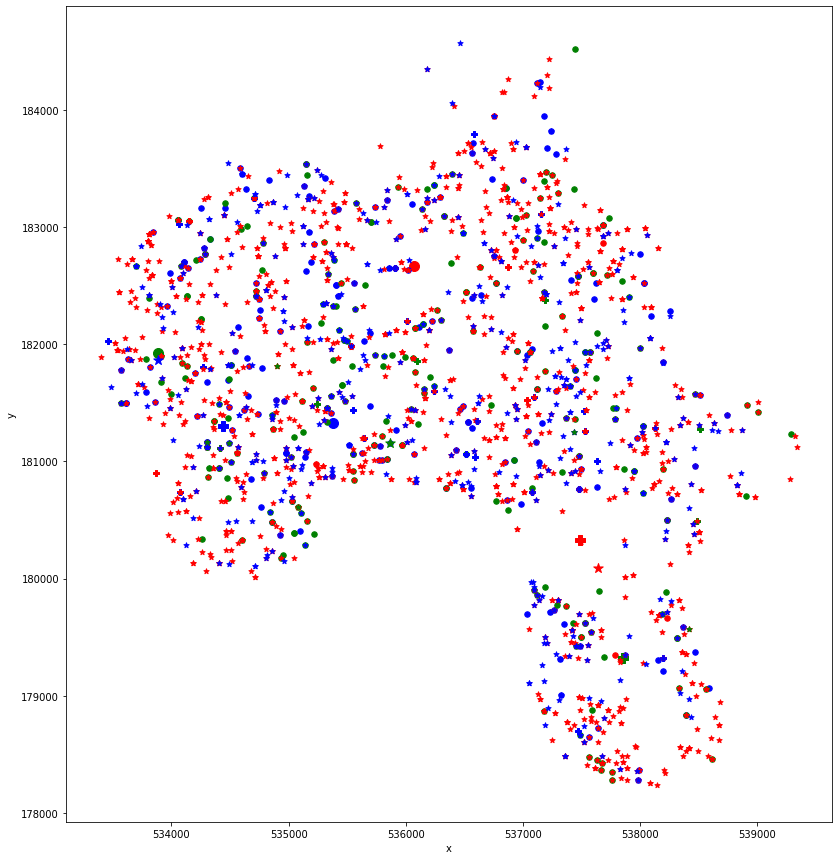

In [32]:
workplaces_to_people = defaultdict(list)
for person_id, workplace_index in enumerate(people_to_workplaces):
    if workplace_index is not None:
        workplaces_to_people[workplace_index].append(person_id)

example_workplaces_to_people = {ind: workplaces_to_people[ind] for ind in workplace_indices}
        
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
marker_styles = [
                ('red', 'o'), ('blue', 'o'), ('green', 'o'),
                ('red', 'P'), ('blue', 'P'), ('green', 'P'),
                ('red', '*'), ('blue', '*'), ('green', '*')
                ]

for (workplace_index, worker_indices), (color, marker) in zip(example_workplaces_to_people.items(), marker_styles):
    trimmed_work.iloc[[workplace_index]].plot(ax=ax, markersize=100, c=color, marker=marker)
    workers = people_df.iloc[worker_indices]
    workers.plot(ax=ax, x='x', y='y', kind='scatter', s=30, c=color, marker=marker)
del fig, ax, workplaces_to_people